Populating the interactive namespace from numpy and matplotlib


/home/local/anaconda3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


DONE (Just in case you aren't paying attention :)


/home/local/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:237: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 258


IndexError: index 125 is out of bounds for axis 1 with size 1

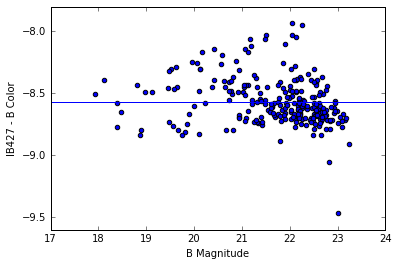

In [2]:
import numpy as np
import matplotlib as plt
from astropy.io import fits
import os
import glob
import re
import shutil
from astropy.io import ascii
from scipy.interpolate import interp1d
from scipy import stats

#NOTE: It's messy as all hell, but this should be run in a folder containing:
#Images to source extract
#Configuration files
#filters
#other SExtractor bits and pieces
#NO subdirectories (until I manage to vet them better)

#Change as needed

path = os.getcwd() + '/'

os.chdir(path)
#Fixed the pathing issue by standardizing what I was doing

all_file_1 = []

for file in glob.glob('*.fits'):
    all_file_1.append(file)

all_files = list(all_file_1)


n = 0

while n < len(all_files):
    all_files[n] = all_files[n].replace("427","")
    all_files[n] = all_files[n].replace("_sci_10","")
    all_files[n] = all_files[n].replace("_sci_20","")
    n = n+1

for i,j in zip(all_file_1,all_files):
    os.rename(i,j)


#print(all_files)

sub_dir = []

for file in all_files:
    os.chdir(path)
    num = str((re.findall('\d+', file))[0])
        
    if not os.path.exists('subaru_' + num):
        os.makedirs('subaru_' + num)
        
        folder_name = 'subaru_' + num
        sub_dir.append(folder_name)
    if "_IB_" in file:
        
        num = str((re.findall('\d+', file))[0])
        folder_name = 'subaru_' + num
                
        test = fits.open(file)
            
        test[0].data[np.where(np.isnan(test[0].data))[0],np.where(np.isnan(test[0].data))[1]] = 65535.
            
        newname_ib = "ib_"+num+"_corr.fits"
            
        test.writeto(path+folder_name+"/" + newname_ib)
            
        test.close()
            
        sex_ib = open(path+"default_ib.sex","r")
            
        newsex_ib = open(path+folder_name+"/ib_"+num+".sex","w")
            
        for line in sex_ib:
            newsex_ib.write(line.replace("DEFAULT_IB",num+"_ib"))
            
        sex_ib.close()
            
        newsex_ib.close()
        
        sex_comb = open("default_comb.sex","r")
            
        newsex_comb = open(path + folder_name + "/" + "comb_" + num + ".sex","w")
            
        for line in sex_comb:
            newsex_comb.write(line.replace("DEFAULT_COMB",num+"_comb"))
            
        sex_comb.close()
        newsex_comb.close()
            
        shutil.move(path+file,path+folder_name+'/'+file)
        
    elif "_B_" in file:
        num = str((re.findall('\d+', file))[0])
        folder_name = 'subaru_' + num
        
        test = fits.open(file)
            
        test[0].data[np.where(np.isnan(test[0].data))[0],np.where(np.isnan(test[0].data))[1]] = 65535.
            
        newname_b = "b_"+num+"_corr.fits"
            
        test.writeto(path+folder_name+"/" + newname_b)
            
        test.close()
            
        sex_b = open(path+"default_b.sex","r")
            
        newsex_b = open(path+folder_name+"/b_"+num+".sex","w")
            
        for line in sex_b:
            newsex_b.write(line.replace("DEFAULT_B",num+"_b"))
            
        sex_b.close()
            
        newsex_b.close()
        shutil.move(path+file,path+folder_name+'/'+file)
            
    shutil.copy2(path+'sub_param.param', path+folder_name+'/sub_param.param')
    shutil.copy2(path+'top_hat_10pix.conv', path+folder_name+'/top_hat_10pix.conv')
    shutil.copy2(path+'default.psf', path+folder_name+'/default.psf')
    shutil.copy2(path+'default.nnw', path+folder_name+'/default.nnw')
    
    os.chdir(path+folder_name)
    
    #os.system("cd /home/sean/Desktop/lya_stuff/"+folder_name)
    os.system("sex b_"+num+"_corr.fits -c b_" + num + ".sex")
    
    #os.system("cd /home/sean/Desktop/lya_stuff/"+folder_name)
    os.system("sex ib_"+num+"_corr.fits -c ib_" + num + ".sex")
    
    #os.system("cd /home/sean/Desktop/lya_stuff/"+folder_name)
    os.system("sex ib_"+num+"_corr.fits,b_"+num+"_corr.fits -c comb_" + num + ".sex")
    
    
print("DONE (Just in case you aren't paying attention :)")
#Christ this is a wreck
#What was I thinking?
#Was I drunk?
#Couldn't have been. Drunk me just realized we've been running SExtractor at least two times for each panel
#Dumbass past-Sean put the call statements outside the bool expressions but inside the main for loop
#So it moves one file over, tries to run SExtractor three times, missing files each time
#Moves another file
#and does it again. That was dumb
#fix that


#Finding everything with a 3-sigma IB427 excess:

color_tot = []
b_mag_tot = []

for i in sub_dir:
    os.chdir(path + i)
    ib_cat = glob.glob("*_ib.cat")[0]
    comb_cat = glob.glob("*_comb.cat")[0]
    
    cat_b = ascii.read(comb_cat)
    cat_ib = ascii.read(ib_cat)
    
    
    b_mag = cat_b['MAG_AUTO']
    ib_mag = cat_ib['MAG_AUTO']

    ib_pos_y = cat_ib['Y_IMAGE']
    ib_pos_x = cat_ib['X_IMAGE']

    cat_num_ib = cat_ib['NUMBER']
    cat_num_b = cat_b['NUMBER']
    
    radius = cat_ib["FLUX_RADIUS"]
    
    color = ib_mag - b_mag
    
    overflow_cut = color < 2.

    
    
    color = color[overflow_cut]
    b_mag = b_mag[overflow_cut]
    ib_pos_x = ib_pos_x[overflow_cut]
    ib_pos_y = ib_pos_y[overflow_cut]
    cat_num_ib = cat_num_ib[overflow_cut]
    cat_num_b = cat_num_b[overflow_cut]
    radius1 =radius[overflow_cut]
    
    overflow_cut2 = (b_mag > 13.) & (b_mag < 30.)

    color = color[overflow_cut2]
    b_mag = b_mag[overflow_cut2]
    ib_pos_x = ib_pos_x[overflow_cut2]
    ib_pos_y = ib_pos_y[overflow_cut2]
    cat_num_ib = cat_num_ib[overflow_cut2]
    cat_num_b = cat_num_b[overflow_cut2]
    radius1 = radius1[overflow_cut2]
    
    plt.scatter(b_mag,color)
    plt.axhline(np.mean(color),color = 'r',label = "Mean")
    plt.axhline(-0.1,color = 'g',label = "Constant Cut")
    plt.axhline(np.mean(color) - 3.*np.std(color),color = 'purple',label = "3-sigma cut")
    plt.legend(loc = "lower left")
    plt.xlabel("B Magnitude")
    plt.ylabel("IB427 - B Color")
    plt.savefig("CMD.png")
    
    plt.close()
    
    for i in color:
        color_tot.append(i)
    for i in b_mag:
        b_mag_tot.append(i)
        
    reg_cut = color < (np.mean(color) - 3. * np.std(color))
    reg_x = ib_pos_x[reg_cut]
    reg_y = ib_pos_y[reg_cut]
    cat_num_ib1 = cat_num_ib[reg_cut]
    cat_num_b1 = cat_num_b[reg_cut]
    reg_color = color[reg_cut]
    reg_rad = radius1[reg_cut]
    
    #create and write a region file for visual check
    region_file = open("ib_excess.reg","w")

    region_file.write("# Region file format: DS9 version 4.0\n")

    for i,j in zip(reg_x,reg_y):
        region_file.write("physical;circle("+str(i)+","+str(j)+",30) # color = green \n")
    
    region_file.close()
    
    
    #Files containing catalog numbers of Lya blob candidates. Can be used to do a np.where later
    ib_candidates = open("ib_candidates.txt","w")
    ib_candidates.write("#   1 NUMBER                 Running object number \n")
    ib_candidates.write("#   2 FLUX_RADIUS            Fraction-of-light radii                                    [pixel] \n")
    ib_candidates.write("#   3 COLOR \n")
    
    i = 0
    while i < len(cat_num_ib1):
        ib_candidates.write(str(cat_num_ib[i])+ "    ")
        ib_candidates.write(str(reg_rad[i])+ "    ")
        ib_candidates.write(str(reg_color[i]) + "\n")
        i = i + 1
    ib_candidates.close()
    
    b_candidates = open("b_candidates.txt","w")
    b_candidates.write("#   1 NUMBER                 Running object number \n")
    b_candidates.write("#   2 FLUX_RADIUS            Fraction-of-light radii                                    [pixel] \n")
    b_candidates.write("#   3 COLOR \n")
    
    i = 0
    while i < len(cat_num_b1):
        b_candidates.write(str(cat_num_b[i])+ "    ")
        b_candidates.write(str(reg_rad[i])+ "    ")
        b_candidates.write(str(reg_color[i]) + "\n")
        i = i + 1
    b_candidates.close()
    
       
    reg_cut2 = color < -8.8
    reg_x2 = ib_pos_x[reg_cut2]
    reg_y2 = ib_pos_y[reg_cut2]
    cat_num_ib2 = cat_num_ib[reg_cut2]
    cat_num_b2 = cat_num_b[reg_cut2]
    reg_color2 = color[reg_cut2]
    reg_rad2 = radius1[reg_cut2]

    #create and write a region file for visual check
    region_file = open("ib_excess_constcut.reg","w")

    region_file.write("# Region file format: DS9 version 4.0\n")

    for i,j in zip(reg_x2,reg_y2):
        region_file.write("physical;circle("+str(i)+","+str(j)+",30) # color = green \n")
    
    region_file.close()
    
    
    #Files containing catalog numbers of Lya blob candidates. Can be used to do a np.where later
    ib_candidates2 = open("ib_candidates_constcut.txt","w")
    ib_candidates2.write("#   1 NUMBER                 Running object number \n")
    ib_candidates2.write("#   2 FLUX_RADIUS            Fraction-of-light radii                                    [pixel] \n")
    ib_candidates2.write("#   3 COLOR \n")
    
    i = 0
    while i < len(cat_num_ib2):
        ib_candidates2.write(str(cat_num_ib2[i])+ "    ")
        ib_candidates2.write(str(reg_rad2[i])+ "    ")
        ib_candidates2.write(str(reg_color2[i]) + "\n")
        i = i + 1
    ib_candidates2.close()
    
    b_candidates2 = open("b_candidates_constcut.txt","w")
    b_candidates2.write("#   1 NUMBER                 Running object number \n")
    b_candidates2.write("#   2 FLUX_RADIUS            Fraction-of-light radii                                    [pixel] \n")
    b_candidates2.write("#   3 COLOR \n")
    
    i = 0
    while i < len(cat_num_b2):
        b_candidates2.write(str(cat_num_b2[i])+ "    ")
        b_candidates2.write(str(reg_rad2[i])+ "    ")
        b_candidates2.write(str(reg_color2[i]) + "\n")
        i = i + 1
    b_candidates2.close()

    
os.chdir(path)

plt.scatter(b_mag_tot,color_tot)
plt.axhline(np.mean(color_tot),color = 'r',label = "Mean")
plt.axhline(-0.1,color = 'g',label = "Constant Cut")
plt.axhline(np.mean(color_tot) - 3.*np.std(color_tot),color = 'purple',label = "3-sigma cut")
plt.legend(loc = "lower left")
plt.xlabel("B Magnitude")
plt.ylabel("IB427 - B Color")
plt.savefig("comb_CMD.png")